# Class 10

## Mar. 19, 2024

By the end of this class, you'll be able to:

- Fit linear regression;

- Know what is spatial data;

- Learn a new package geopandas;

- Do some basic spatial analysis (we'll learn more in next 2 weeks!)

# Review of linear regression

## What is the effect of recent immigration on asthma rates in Toronto neighbourhoods?

### Data

- Data from <http://torontohealthprofiles.ca> contains data on asthma and immigration for each neighbourhood in Toronto.

#### Sociodemographic data

- Read sociodemographic data from the excel file `1_socdem_neighb_2006-2.xls` with sheet name `socdem_2006` into `pandas` using `read_excel`.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols


In [2]:
fname = '1_socdem_neighb_2006-2.xls'
sname = 'socdem_2006'
socdem_neighb = pd.read_excel(fname, sheet_name = sname, header = 10) # the table starts in row #11
socdem_neighb.head()

,Neighbourhood id,Neighbourhood Name,Total Population,% 19 and under,% 65 and over,% Living alone,% Aged 65+ living alone,% Lone parent families §,% 1 year mobility in population,Median household income before-tax $,...,% Less than high school education **,% With a University degree **,% No knowledge of English/French,% Recent immigrants-within 5 years,% Recent immigrants-within 10 years,% Immigrants,% Visible minority,"Top 3 Home Languages for non-English speaking households, #1","Top 3 Home Languages for non-English speaking households, #2","Top 3 Home Languages for non-English speaking households, #3"
0,1,West Humber-Clairville,32252,26.8,11.3,3.7,11.7,26.3,11.6,63413,...,18.4,22.9,5.4,12.2,22.1,60.0,77.9,Panjabi (Punjabi),Gujarati,Spanish
1,2,Mount Olive-Silverstone-Jamestown,32127,32.2,8.1,4.1,15.4,31.5,15.7,48146,...,20.1,23.6,7.6,22.2,35.1,67.1,85.3,Panjabi (Punjabi),Gujarati,Arabic
2,3,Thistletown-Beaumond Heights,9928,25.3,16.7,5.4,17.5,30.1,10.9,55032,...,16.7,20.7,5.0,9.7,19.3,55.9,53.8,Panjabi (Punjabi),Italian,Spanish
3,4,Rexdale-Kipling,10725,23.6,18.3,10.2,28.8,33.3,13.2,52428,...,15.3,18.8,3.0,8.3,14.0,47.2,41.8,Spanish,Panjabi (Punjabi),Croatian
4,5,Elms-Old Rexdale,9437,29.9,10.5,5.8,13.0,39.1,9.7,53779,...,15.2,18.8,3.6,9.8,18.2,53.8,60.5,Spanish,Italian,Urdu


Which column should we select to measure immigration?  There are several choices.

In [3]:
socdem_neighb.columns

Index(['Neighbourhood id', 'Neighbourhood Name', 'Total Population',
       '% 19 and under', '% 65 and over', '% Living alone',
       '% Aged 65+ living alone', '% Lone parent families §',
       '% 1 year mobility in population',
       'Median household income before-tax $',
       'Median household income after-tax $ ‡',
       '% Families-Incidence of low income before-tax',
       '% Families-Incidence of low income after-tax ‡',
       '% Individuals-Incidence of low income before-tax',
       '% Individuals-Incidence of low income after-tax ‡',
       '% Rented Dwellings', '% Unemployment rate *',
       '% Not in labour force *', '% Less than high school education **',
       '% With a University degree **', '% No knowledge of English/French',
       '% Recent immigrants-within 5 years',
       '% Recent immigrants-within 10 years', '% Immigrants',
       '% Visible minority',
       'Top 3 Home Languages for non-English speaking households, #1',
       'Top 3 Home Languages 

- Let's use `'% Recent immigrants-within 5 years'` to represent recent immigrants in a neighborhood.

- Later on we will want a few more sociodemographic columns, so let's create a new `DataFrame` and rename the columns.

In [4]:
cols = ['Neighbourhood id', 'Neighbourhood Name', 
        'Median household income after-tax $ ‡', 
        '% Rented Dwellings', '% Unemployment rate *', 
        '% Recent immigrants-within 5 years', '% Visible minority']

socdem_neighb = socdem_neighb[cols]

colnames = {cols[0] : 'Neighbid',
            cols[1] : 'name',
            cols[2] : 'median_income',
            cols[3] : 'rented_dwell',
            cols[4] : 'unemployment',
            cols[5] : 'immigration5',
            cols[6] : 'vismin'}

socdem_neighb = socdem_neighb.copy()

socdem_neighb.rename(columns = colnames, inplace = True)

In [5]:
socdem_neighb.head()

,Neighbid,name,median_income,rented_dwell,unemployment,immigration5,vismin
0,1,West Humber-Clairville,56220,27.4,7.0,12.2,77.9
1,2,Mount Olive-Silverstone-Jamestown,43975,52.0,9.9,22.2,85.3
2,3,Thistletown-Beaumond Heights,49800,34.4,6.3,9.7,53.8
3,4,Rexdale-Kipling,46033,45.1,7.7,8.3,41.8
4,5,Elms-Old Rexdale,48055,41.2,7.8,9.8,60.5


#### Asthma data

- Read data from the excel file `1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls` with sheet name `1_ahd_neighb_asthma_2007` into `pandas` using `read_excel`.

In [6]:
fname = '1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls'
sname = '1_ahd_neighb_asthma_2007'

asthma_neighb = pd.read_excel(fname, sheet_name = sname, header = 11) #the table starts with row #12
asthma_neighb.head()

,Unnamed: 0,Unnamed: 1,Demographics ª,% With asthma,LL (95% CI),UL (95% CI),Demographics ª.1,% With asthma.1,LL (95% CI) .1,UL (95% CI) .1,...,Demographics ª.7,% With asthma.7,LL (95% CI) .7,UL (95% CI) .7,Demographics ª.8,% With asthma.8,LL (95% CI) .8,UL (95% CI) .8,Rate Ratio**.2,H/L/NS.2
0,1,West Humber-Clairville,11977,9.7,9.2,10.2,11770,10.6,10.0,11.2,...,4435,12.3,11.3,13.3,8921,10.9,10.3,11.6,1.07,H
1,2,Mount Olive-Silverstone-Jamestown,11157,7.9,7.4,8.4,11462,10.2,9.6,10.8,...,3819,13.5,12.5,14.6,7726,11.2,10.5,11.9,1.10,H
2,3,Thistletown-Beaumond Heights,3307,9.4,8.4,10.4,3322,10.5,9.5,11.6,...,1307,12.3,10.5,14.1,2587,10.8,9.6,12.0,1.06,NS
3,4,Rexdale-Kipling,3317,9.7,8.7,10.7,3438,13.0,11.9,14.2,...,1468,13.2,11.5,14.9,2897,10.4,9.3,11.5,1.02,NS
4,5,Elms-Old Rexdale,3209,10.2,9.1,11.2,3379,13.0,11.8,14.1,...,1314,15.1,13.1,17.0,2610,11.8,10.6,13.0,1.16,H


- The asthma rates are broken down by sex and age.  

- Which rates should we choose?  

- For this example, let's select asthma rates for both sexes age 20 - 64.

In [7]:
asthma_neighb.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Demographics ª', '% With asthma',
       'LL (95% CI) ', 'UL (95% CI) ', 'Demographics ª.1', '% With asthma.1',
       'LL (95% CI) .1', 'UL (95% CI) .1', 'Demographics ª.2',
       '% With asthma.2', 'LL (95% CI) .2', 'UL (95% CI) .2', 'Rate Ratio**',
       'H/L/NS', 'Demographics ª.3', '% With asthma.3', 'LL (95% CI) .3',
       'UL (95% CI) .3', 'Demographics ª.4', '% With asthma.4',
       'LL (95% CI) .4', 'UL (95% CI) .4', 'Demographics ª.5',
       '% With asthma.5', 'LL (95% CI) .5', 'UL (95% CI) .5', 'Rate Ratio**.1',
       'H/L/NS.1', 'Demographics ª.6', '% With asthma.6', 'LL (95% CI) .6',
       'UL (95% CI) .6', 'Demographics ª.7', '% With asthma.7',
       'LL (95% CI) .7', 'UL (95% CI) .7', 'Demographics ª.8',
       '% With asthma.8', 'LL (95% CI) .8', 'UL (95% CI) .8', 'Rate Ratio**.2',
       'H/L/NS.2'],
      dtype='object')

In [8]:
# Select the neghborhood_id, neighborhood_name, and both sexes with asthma

important_cols = asthma_neighb.columns[[0, 1, 11]]

colnames = {important_cols[0]: 'Neighbid',
           important_cols[1] : 'name',
           important_cols[2] : 'asthma_pct'}

asthma_rates = asthma_neighb.copy()

asthma_rates = asthma_rates[important_cols]

asthma_rates.rename(columns = colnames, inplace=True)

asthma_rates.head()

,Neighbid,name,asthma_pct
0,1,West Humber-Clairville,10.2
1,2,Mount Olive-Silverstone-Jamestown,9.1
2,3,Thistletown-Beaumond Heights,10.0
3,4,Rexdale-Kipling,11.4
4,5,Elms-Old Rexdale,11.6


### Merge Sociodemographic and asthma data

- To examine the relationship between asthma and immigration we will need to merge `socdem_neighb` and `asthma_rates`.

- The `DataFrame`s can be merged on neighbourhood id.

In [9]:
# Two datasets are merged based on neighborhood id

asthma_socdem = asthma_rates.merge(socdem_neighb, left_on='Neighbid', right_on='Neighbid')

asthma_socdem.head()

,Neighbid,name_x,asthma_pct,name_y,median_income,rented_dwell,unemployment,immigration5,vismin
0,1,West Humber-Clairville,10.2,West Humber-Clairville,56220,27.4,7.0,12.2,77.9
1,2,Mount Olive-Silverstone-Jamestown,9.1,Mount Olive-Silverstone-Jamestown,43975,52.0,9.9,22.2,85.3
2,3,Thistletown-Beaumond Heights,10.0,Thistletown-Beaumond Heights,49800,34.4,6.3,9.7,53.8
3,4,Rexdale-Kipling,11.4,Rexdale-Kipling,46033,45.1,7.7,8.3,41.8
4,5,Elms-Old Rexdale,11.6,Elms-Old Rexdale,48055,41.2,7.8,9.8,60.5


## A regression model of asthma on immigration

### Plot the data

- What are the dependent and independent variables?

- Does the relationship look linear?

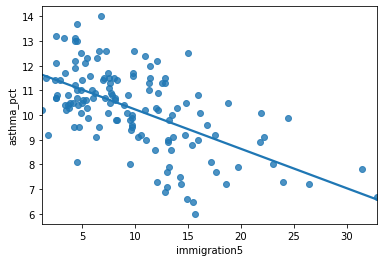

In [10]:
sns.regplot(y = 'asthma_pct', x = 'immigration5', data = asthma_socdem, ci = None);

Describe the relationship between asthma and immigration.

### Fit the regression model

In [11]:
reg_asthmaimm = ols('asthma_pct ~ immigration5', data = asthma_socdem) # setup the model

reg_asthmaimm_fit = reg_asthmaimm.fit() # estimate/fit the model 

### Statistical summary of the regression model

In [12]:
reg_asthmaimm_summ = reg_asthmaimm_fit.summary()

reg_asthmaimm_summ.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.8266,0.218,54.328,0.000,11.396,12.257
immigration5,-0.1597,0.019,-8.475,0.000,-0.197,-0.122


#  The regression model is the equation:

$$\texttt{asthma_pct} = 11.8266  - 0.1597 \times \texttt{immigration5}$$

- The **slope** indicates that for a 1% **increase** in immigration in the past 5 years the percentage of asthma cases in a neighbourhood **decrease** by 0.1597%.

- The **y-intercept** indicates that when a neighbourhood has 0% immigration the past 5 years then asthma rates are 11%.  

- Are there any neighbourhoods with 0% immigration in the past 5 years?

In [13]:
asthma_socdem['immigration5'].describe()

count    140.000000
mean       9.864286
std        6.037045
min        1.200000
25%        4.975000
50%        8.650000
75%       13.100000
max       32.800000
Name: immigration5, dtype: float64

- The **y-intercept** in regression models often doesn't have a sensible interpretation, but is often mathematically important for regression to work well.

## Accuracy of the regression model 

In [14]:
reg_asthmaimm_fit.rsquared

0.34233239704200125

Text(0, 0.5, 'residuals')

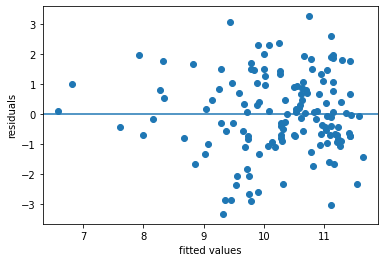

In [15]:
plt.scatter(x = reg_asthmaimm_fit.fittedvalues , y = reg_asthmaimm_fit.resid)
plt.axhline(y = 0)
plt.xlabel('fitted values')
plt.ylabel('residuals')

- The R-squared statistics indicates a relatively good explanation of the model (quite larger than 0)

- The residual plot indicates some important variables are missing, as we can see larger abolute values as fitted values increase (not a random distributed pattern)

### Summary

Therefore, we can conclude that the immigration rate in recent 5 years in a neighborhood is negatively associated with the prevalence of asthma in the neighborhood.

Why not causal relationship?

What is the implication?


## Training and testing a model

- Ideally we could assess the accuracy of this linear regression model on a new set of data (i.e., immigration rates in Toronto neighbourhoods in future years.) 

- But, we don't have this data.

- One trick that data scientists use to fit the model on part of the data (training data) and use the remaining part (testing data) to test the accuracy.

- If we only have one data set then the training data can be obtained by randomly selecting rows from the data to fit the regression model, then the remaining rows can be used to test the accuracy of the model.

### Splitting a `pandas` `DataFrame` by `index`

In [16]:
data = {'a' : [1, 2, 3, 4, 5]}

df = pd.DataFrame(data)

df.index

RangeIndex(start=0, stop=5, step=1)

A Boolean array that is `True` if the index is `0` or `1` and `False` otherwise. 

In [17]:
df.index.isin([0,1])

array([ True,  True, False, False, False])

In [18]:
df[df.index.isin([0,1])]

,a
0,1
1,2


To create a Boolean series that is `False` if the index is `0` or `1` and `True` otherwise we can negate `df.index.isin([0,1])` this Boolean series using the `~` operator `~df.index.isin([0,1])`

In [19]:
~df.index.isin([0,1])

array([False, False,  True,  True,  True])

In [20]:
df[~df.index.isin([0,1])]

,a
2,3
3,4
4,5


### Creating training and test data sets from a single dataset

### Step 1: 

- split the data into a training set with 75% of the rows.

- use the remaining 25% of the data for testing. 

In [21]:
np.random.seed(11) # for reproducibility

# randomly select 75% of neighbourhoods
reg_df_train = asthma_socdem.sample(frac = 0.75, replace = False) 

# get index of training data
train_index = reg_df_train.index

- Exclude indicies from `reg_df_train` using `pandas` `isin` function. 

In [22]:
# exclude rows in training to define test data
reg_df_test = asthma_socdem[~asthma_socdem.index.isin(train_index)]

print(asthma_socdem.shape)

print(reg_df_train.shape)

print(reg_df_test.shape)

(140, 9)
(105, 9)
(35, 9)


### Step 2: Fit the regression model on the training data

In [23]:
reg_train = ols('asthma_pct ~ immigration5', data = reg_df_train) # setup the model

reg_train_fit = reg_train.fit() # estimate/fit the model 

### Step 3: Compute fitted values using training data 

In [24]:
# use the model fit on the training data to predict asthma rates
# from the test set. 

predvalues_train = reg_train_fit.fittedvalues

# Another way to compute
# predvalues_train = reg_train_fit.predict(reg_df_train['immigration5'])

### Step 4: Evaluate accuracy using root mean-squared error on training data

- Another measure of accuracy of regression models.

- Compares observed values of the dependent variable with the predicted values.

![rmse.jpg](insights_rmse_formula.jpg)



It can be computed using the `rmse` function from `statsmodels`.


In [25]:
# Compute root mean-squared error for the training data.
from statsmodels.tools.eval_measures import rmse

rmse(predvalues_train, reg_df_train['asthma_pct'])


1.3987103239995489

- The observed asthma rates deviate from the predicted asthma rates in each neighbourhood by 1.4% in the training set.

- Is this an acceptable prediction error?

- Let's examine the accuracy of the linear regression model on the test set


### Step 5: Evaluate the accuracy of regression model on the test data using root mean-squared error

- Compute predictions using test data

In [26]:
predvalues_test = reg_train_fit.predict(reg_df_test['immigration5'])


- Now compute the root mean-squared error for the test data using the model fit on the training data.

In [27]:
rmse(predvalues_test, reg_df_test['asthma_pct'])


1.1096219805062997

## Conclusion of data analysis using linear regression model

- The regression model appears to provide an accurate fit the data, although both the scatter plot and plot of residuals indicate that there is a lot of variation in asthma rates in neighbourhoods when the immigrations rates are small (between 10%-20%).

- As the percentage of immigrants to a neighbourhood within the last 5 years increases, the asthma rates will decreases. 

- Regression analyses on aggregated data such as neighbourhoods can be misleading when compared to non-aggregated data.

## Are there other sociodemographic  factors in our data that might effect asthma rates?

- Let's create a matrix scatter plot using [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) in the `seaborn` library.

- `pairplot` will visualize paired relationship between variables in a dataset.

In [28]:
asthma_socdem.columns

Index(['Neighbid', 'name_x', 'asthma_pct', 'name_y', 'median_income',
       'rented_dwell', 'unemployment', 'immigration5', 'vismin'],
      dtype='object')

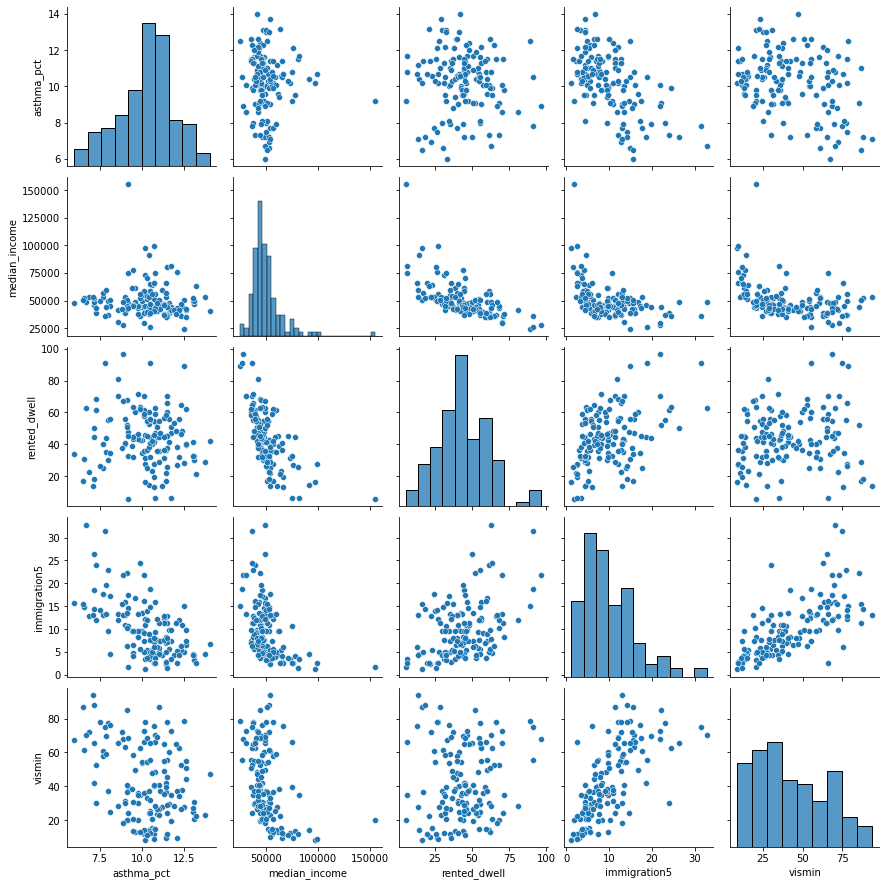

In [29]:
# reduce the column for better presentation
to_show = ['asthma_pct','median_income','rented_dwell','immigration5','vismin']
sns.pairplot(asthma_socdem[to_show]);

- Let's consider median income

- Fit the regression model on all the data and produce a statistical summary.

In [30]:
reg_asthmaimmunem = ols('asthma_pct ~ immigration5 + median_income', data = asthma_socdem) # setup the model

reg_asthmaimmunem_fit = reg_asthmaimmunem.fit() # estimate/fit the model 

reg_asthmaimmunem_summ = reg_asthmaimmunem_fit.summary()

reg_asthmaimmunem_summ.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.3041,0.497,28.758,0.000,13.321,15.288
immigration5,-0.2054,0.019,-10.750,0.000,-0.243,-0.168
median_income,-4.048e-05,7.45e-06,-5.431,0.000,-5.52e-05,-2.57e-05


- Notice that the slope estimate (coefficient) for `median_income` is 0, but so is the p-value and range of plausible values.

- That seems odd.  What's happening?

- We can see from the scatter plot that `immigration5` and `median_income` have a linear relationship.  

- When two variables have a linear relationship multiple linear regression models produce strange results.

- It's important that independent variables in a multiple regression model are unrelated.

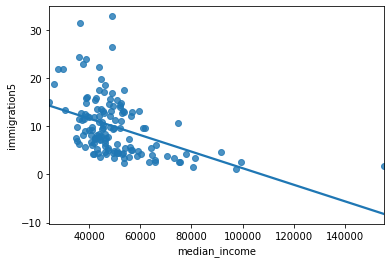

In [31]:
sns.regplot(y = 'immigration5', x = 'median_income', data = asthma_socdem, ci = None);

## A quick review of linear regression

- Step 1: prepare data (Which dataset I want to import? Which variables I want to analyze? How I can 'wrangle' the data, i.e., produce new variables and merge them into one dataframe for further analysis?)

- Step 2: Explore pair relationship (Using `sns.pairplot` to explore potential relationships. Is there a linear relationship?)

- Step 3: Fit model

- Step 4: Accuracy (Which indicators I want to use? e.g., r-squared, residual plot, RMSE)

- Step 5: Display the full model and explain (What does the model mean?)

# Introduction to spatial data

## Why Spatial Data Matters

#### What are spatial data? 

Spatial data are data that have some geographic attribute(s). So you can think of it like each row having a pointer to where the row goes on a map.

#### Why do we want spatial data? 

By locating things on a map, we can look for how certain variables present vary across space. We can look for things like clustering of high values or cold spots (aka hot spots/cold spots) or dispersal. Patterns across space can reveal interesting drivers of social phenomena.  



![toronto income](https://preview.redd.it/xisicselj7t21.jpg?width=960&crop=smart&auto=webp&s=541f2d6a7f83deea324230f885831c8a84b2cb45)

## Types of Spatial Data

### raster data & vector data

![vector and raster](https://cdn.safe.com/wp-content/uploads/2021/10/13090609/Raster-VS-Vector-1.png)


#### Raster data

For example, satellite and aerial images

![landsat data](https://upload.wikimedia.org/wikipedia/commons/b/bf/Toronto_Landsat.jpg)

#### Vector data

For example, points, lines, and polygons

![points lines polys](https://community.alteryx.com/t5/image/serverpage/image-id/49570i26EF3FAEACD21BD4/image-size/medium?v=1.0&px=400)

## How are these data stored in a computer?

There are many ways!

#### Generally raster data are stored as a matrix

![matrix raster](https://www.researchgate.net/profile/Bartosz-Mitka-2/publication/269336365/figure/fig1/AS:650423912374277@1532084553146/The-matrix-of-Regular-Raster-Grid-model-containing-elevations-of-terrain-Elevations-of.png)



#### Vector data is stored in many different ways...

Two common ones are `geojson` and `shapefiles`.

What are these files made of? 

Geojson is pretty straightforward:

![geojson example](http://djjr-courses.wdfiles.com/local--files/soc128:images-coding/GEOJSON-format01.png)

Shapefiles are more complicated and involve multiple distinct files that contain information about spatial locations, coordinate systems and projections, attributes, etc. We'll focus on geojson for this class.

# Introducing GeoPandas

## How do we work with spatial data in python?

We're going to use something called 'geopandas'

https://geopandas.org/en/stable/

There are a few other libraries that we need, like mapclassify. There are a lot of different tools out there, but we'll stick to these two (and the xls reader) for today

In [32]:
# # Let's install and then load libraries
# import sys
# !{sys.executable} -m pip install geopandas
# !{sys.executable} -m pip install mapclassify
# !{sys.executable} -m pip install xlrd


In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import xlrd

### Now we want to import a spatial data file. 

We'll be working with two spatial data files today: 
`Toronto_Neighbourhoods.geojson` and `toronto_rails.geojson`

We'll also use the health data we were playing with last week:
`1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls`

#### To load the spatial data we need to create something known as a geodataframe:

In [34]:

nbrhd = gpd.GeoDataFrame.from_file("Toronto_Neighbourhoods.geojson") ## Like pd.read_xxx(file_name)
nbrhd.head()

,AREA_ATTR_ID,AREA_DESC,AREA_ID,AREA_LONG_CODE,AREA_NAME,AREA_SHORT_CODE,CLASSIFICATION,CLASSIFICATION_CODE,LATITUDE,LONGITUDE,OBJECTID,PARENT_AREA_ID,Shape__Area,Shape__Length,X,Y,_id,geometry
0,26005521,Casa Loma (96),2480141,096,Casa Loma (96),096,None,None,None,None,17545105,None,3.678385e+06,8214.176485,None,None,1,"POLYGON ((-79.41469 43.67391, -79.41485 43.674..."
1,26005520,Annex (95),2480140,095,Annex (95),095,None,None,None,None,17545121,None,5.337192e+06,10513.883143,None,None,2,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
2,26005519,Caledonia-Fairbank (109),2480139,109,Caledonia-Fairbank (109),109,None,None,None,None,17545137,None,2.955857e+06,6849.911724,None,None,3,"POLYGON ((-79.46021 43.68156, -79.46044 43.681..."
3,26005444,Woodbine Corridor (64),2480064,064,Woodbine Corridor (64),064,None,None,None,None,17545153,None,3.052518e+06,7512.966773,None,None,4,"POLYGON ((-79.31485 43.66674, -79.31660 43.666..."
4,26005443,Lawrence Park South (103),2480063,103,Lawrence Park South (103),103,None,None,None,None,17545169,None,6.211341e+06,13530.370002,None,None,5,"POLYGON ((-79.41096 43.70408, -79.41165 43.703..."


In [35]:
# Let's look at the geometry column - this is the data that 
# describes the polygon representing the first neighbourhood

print(nbrhd.loc[0,'geometry'])

POLYGON ((-79.41469317817781 43.6739104164259, -79.41484930122832 43.6743388247927, -79.4155279126094 43.67606998537741, -79.4157867581137 43.6767302521386, -79.4164385645546 43.6783329020511, -79.4165782543862 43.6787785512344, -79.4167583944682 43.6792484522149, -79.41698203537291 43.6798247440047, -79.4170902471251 43.6801047004014, -79.4174797570886 43.681051830379, -79.4176666295158 43.6815699096212, -79.4176976020857 43.68163169892501, -79.4178116560388 43.6819252777403, -79.4181213711598 43.6827105222857, -79.4182734938897 43.6830961662335, -79.418301440907 43.683167503583, -79.4184313411692 43.6834966841996, -79.4184870757371 43.6836294842548, -79.4185410795905 43.6837582054538, -79.4184092922561 43.683786393574, -79.4182955283344 43.6834937157887, -79.4154265333151 43.684065660547, -79.4135200432832 43.6844456915062, -79.4134087861596 43.6844695957643, -79.4134686959176 43.6846245536214, -79.4124643275333 43.6848288476745, -79.4118960009694 43.6849418545125, -79.4126020656339 

In [36]:
# Otherwise we can continue to treat the variable like a dataframe ... 
# it's what we have been doing all along!

nbrhd_names = nbrhd["AREA_NAME"]
type(nbrhd_names)

pandas.core.series.Series

### Now if we want to make a map, what do we do? 

It's easy! You can "plot" a geodataframe and geopandas will make it a map!

<AxesSubplot:>

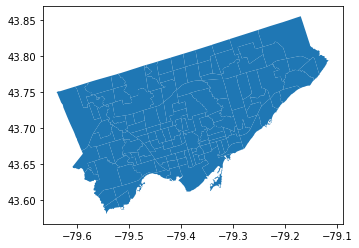

In [37]:
nbrhd.plot() 

### That's nice...

But we want to be a little more sophisticated with our maps.

![basic_gif](basic.gif "basic")

The next cell goes through a better way to create a map "figure".

Let's first create `Figure` and `Axes` objects.

![fig and ax](matplotlib_figure_axes_axis.png)

First, let's use `plt.subplots` to create a figure variable "fig" and an axes variables called "ax".

The first line of code sets the stage - it says how many images - by rows/columns, and we can set other figure attributes in here, like figure size using figsize.


To plot the map, we need to call the plot command `.plot` like before, but this time we want to say which 'cell' or ax cell it will go in, i.e., `ax=axes`. We also can use the `column` parameter to shade each row (that represents a polygon) by an attribute value.


<class 'matplotlib.figure.Figure'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


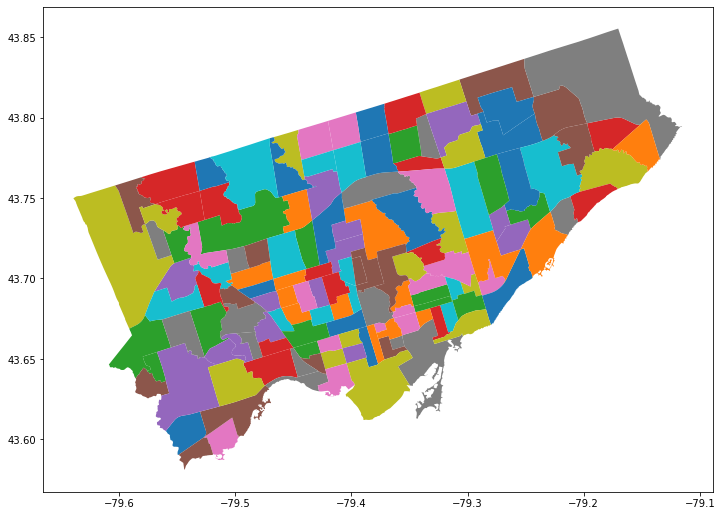

In [38]:
fig, axes = plt.subplots(1, 1, figsize = (12,12))

print(type(fig)) #Figure object is like the sheet we are drawing on
print(type(axes))  #AxesSubplots are like cells within the sheet

nbrhd.plot(column = "AREA_NAME", ax = axes);

What if we want to do 2 maps in one figure?


(2,)


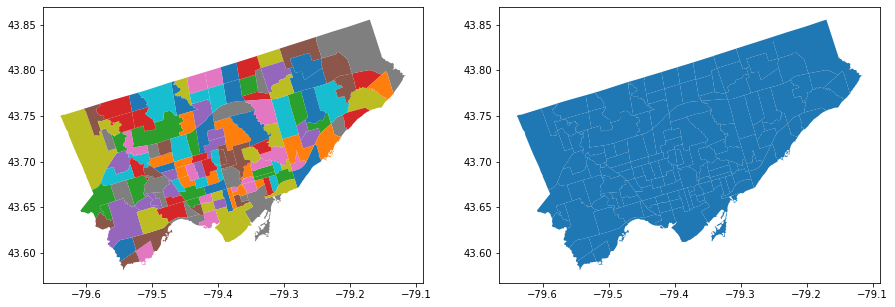

In [39]:

fig, axes = plt.subplots(1, 2)

#notice there are just 2 things in the axes object
print(axes.shape)

# pick the first cell in the figure
ax = axes[0]
nbrhd.plot(column = "AREA_NAME",
           ax=ax)

# pick the second cell in the figure
ax = axes[1]
nbrhd.plot(ax=ax)

#resize
current_fig = plt.gcf() #get current figure aka gcf
current_fig.set_size_inches(15,10) #set figure width
current_fig.savefig('torontomaps.png',dpi=100) #export maps as an image file!

A note about axes:

- if you only has one 'axes' (i.e., plt.subplots(1,1)) then you can just say `ax = axes`
- if you have a 1 row and multiple columns or multiple rows and 1 column, then you would say `ax = axes[n]` where `n` is the axes cell you'd like to put the figure in
- if you have a matrix of cells of axes (i.e., plt.subplots(2,2)) then you need to say `ax = axes[n][m]` where `n` is the row number and `m` is the column number of the cell

#### Let's try with a column that contains a number... what happens there? 

let's also add a new parameter "cmap" = [color map](https://matplotlib.org/stable/tutorials/colors/colormaps.html) and a legend.


This link will provide more info on other things we can do with plotting geodataframes: 
https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html

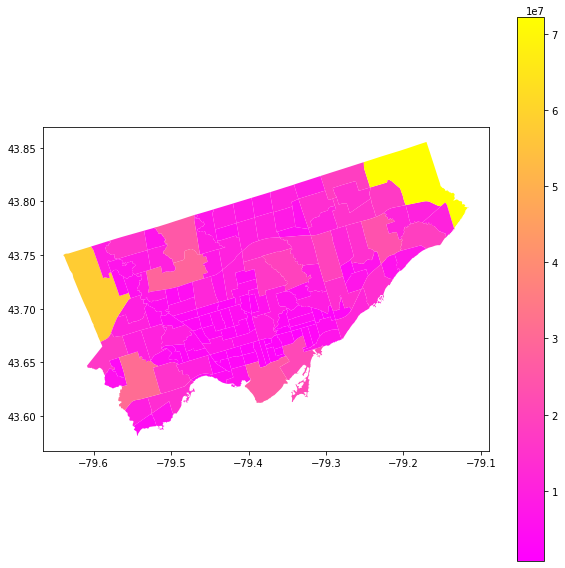

In [40]:
fig, axes = plt.subplots(1,1)

# We want to plot the area of each neighborhood
nbrhd.plot(column = "Shape__Area", ax = axes, 
           cmap = "spring", legend = True)

current_fig = plt.gcf()
current_fig.set_size_inches(10, 10)

### let's try again with neighbourhoods:

<AxesSubplot:>

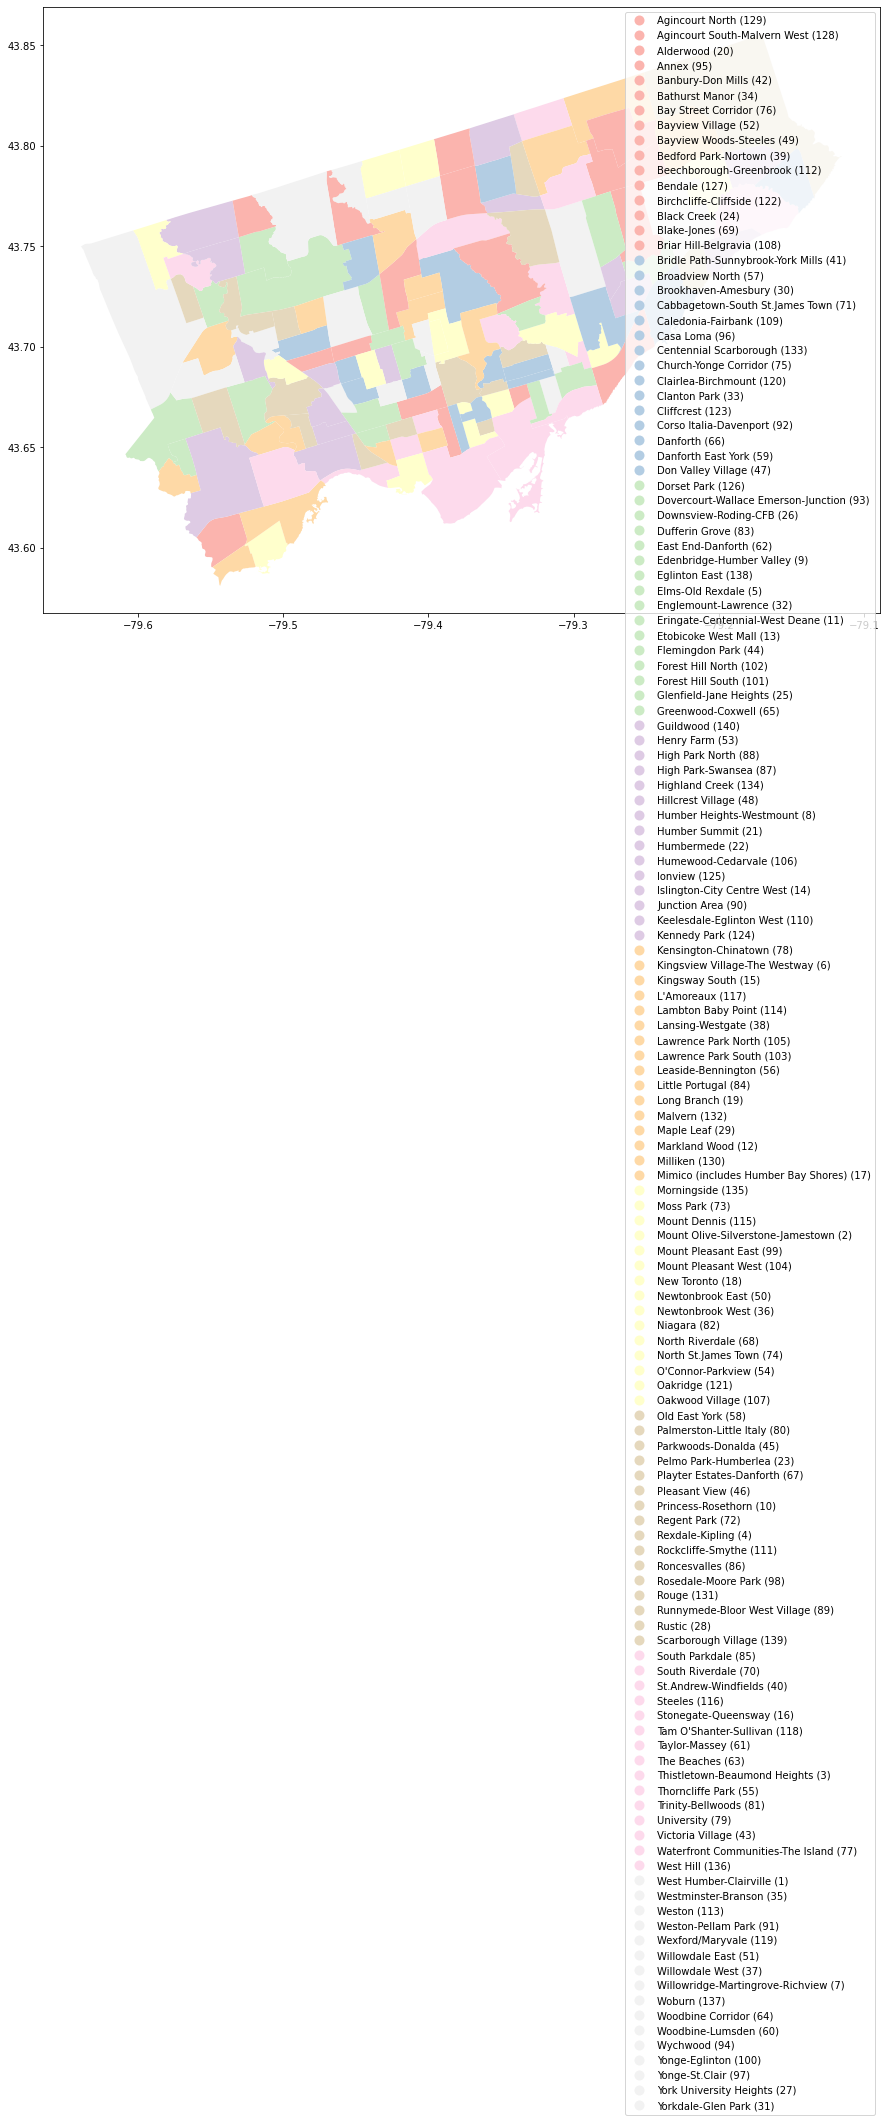

In [41]:
#another way to resize
fig, axes = plt.subplots(1,1, figsize = (15,15))


nbrhd.plot(column = "AREA_NAME", ax = axes,
           cmap = "Pastel1", legend = True)


... These are silly maps. Who cares how big the neighbourhoods are or who can deal with a weird pastel map with a legend that is way too big... 

#### We want to know what is happening inside of them!

How do we bring two pieces of info together? How do we bring data from a table into a geodataframe?

We can use joins! Remember those?


###  How do we bring data from a table into a geodataframe?

We can use `merge`, just like what we did before!

Let's join the asthma rates into the neighborhood and map them out.

In [42]:
# simplify the geodataframe ready

important_spat_cols = nbrhd.columns[[4, 5, 17]]
colnames_spat = {important_spat_cols[0]: 'name',
           important_spat_cols[1] : 'nbrhd_spat_id',
           important_spat_cols[2] : 'geometry'}

nbrhd_simple = nbrhd.copy()

nbrhd_simple = nbrhd_simple[important_spat_cols]

nbrhd_simple.rename(columns = colnames_spat, inplace=True)

# Notice that the "nbrhd_spat_id" is a string and not a number... that may be an issue
print("The data type of nbrhd_spat_id is: ", type(nbrhd_simple["nbrhd_spat_id"][0]))
nbrhd_simple.head()

The data type of nbrhd_spat_id is:  <class 'str'>


,name,nbrhd_spat_id,geometry
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674..."
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681..."
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.31660 43.666..."
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703..."


In [43]:
#get the asthma data

fname = '1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls' #file name
sname = '1_ahd_neighb_asthma_2007' #sheet name in excel file

#store excel sheet with asthma data in a dataframe variable
asthma_neighb = pd.read_excel(fname, sheet_name = sname, header = 11)
asthma_neighb.head()

,Unnamed: 0,Unnamed: 1,Demographics ª,% With asthma,LL (95% CI),UL (95% CI),Demographics ª.1,% With asthma.1,LL (95% CI) .1,UL (95% CI) .1,...,Demographics ª.7,% With asthma.7,LL (95% CI) .7,UL (95% CI) .7,Demographics ª.8,% With asthma.8,LL (95% CI) .8,UL (95% CI) .8,Rate Ratio**.2,H/L/NS.2
0,1,West Humber-Clairville,11977,9.7,9.2,10.2,11770,10.6,10.0,11.2,...,4435,12.3,11.3,13.3,8921,10.9,10.3,11.6,1.07,H
1,2,Mount Olive-Silverstone-Jamestown,11157,7.9,7.4,8.4,11462,10.2,9.6,10.8,...,3819,13.5,12.5,14.6,7726,11.2,10.5,11.9,1.10,H
2,3,Thistletown-Beaumond Heights,3307,9.4,8.4,10.4,3322,10.5,9.5,11.6,...,1307,12.3,10.5,14.1,2587,10.8,9.6,12.0,1.06,NS
3,4,Rexdale-Kipling,3317,9.7,8.7,10.7,3438,13.0,11.9,14.2,...,1468,13.2,11.5,14.9,2897,10.4,9.3,11.5,1.02,NS
4,5,Elms-Old Rexdale,3209,10.2,9.1,11.2,3379,13.0,11.8,14.1,...,1314,15.1,13.1,17.0,2610,11.8,10.6,13.0,1.16,H


In [44]:
#let's simplify this by only pulling a few relevant columns
important_cols = asthma_neighb.columns[[0, 1, 11]]
colnames = {important_cols[0]: 'Neighbid',
           important_cols[1] : 'name',
           important_cols[2] : 'asthma_pct'}

asthma_rates = asthma_neighb.copy()

asthma_rates = asthma_rates[important_cols]

asthma_rates.rename(columns = colnames, inplace=True)

print("The data type of Neighbid is: ", type(asthma_rates["Neighbid"][0]))
asthma_rates.head()


The data type of Neighbid is:  <class 'numpy.int64'>


,Neighbid,name,asthma_pct
0,1,West Humber-Clairville,10.2
1,2,Mount Olive-Silverstone-Jamestown,9.1
2,3,Thistletown-Beaumond Heights,10.0
3,4,Rexdale-Kipling,11.4
4,5,Elms-Old Rexdale,11.6


### Note that the `nbrhd_spat_id` in Neighborhood GeoDataFrame is string

Let's convert it into a number. 


In [45]:
# Create a new variable in the nbrhd_simple geodataframe and store the new number
# version of the neighbourhood id here
nbrhd_simple["Neighbid"] = nbrhd_simple["nbrhd_spat_id"].astype(int)

# we can sort by the id - and check to see if they line up with the asthma data 
nbrhd_simple.sort_values('Neighbid').head()


,name,nbrhd_spat_id,geometry,Neighbid
30,West Humber-Clairville (1),001,"POLYGON ((-79.55236 43.70947, -79.55238 43.709...",1
40,Mount Olive-Silverstone-Jamestown (2),002,"POLYGON ((-79.60338 43.75786, -79.60205 43.758...",2
124,Thistletown-Beaumond Heights (3),003,"POLYGON ((-79.57751 43.73384, -79.57806 43.734...",3
122,Rexdale-Kipling (4),004,"POLYGON ((-79.55512 43.71510, -79.55504 43.714...",4
22,Elms-Old Rexdale (5),005,"POLYGON ((-79.55512 43.71510, -79.55569 43.716...",5


#### Now let's do the join!

In [46]:
nbrhd_simple = nbrhd_simple.merge(asthma_rates, on="Neighbid")
nbrhd_simple.head()

,name_x,nbrhd_spat_id,geometry,Neighbid,name_y,asthma_pct
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,10.1
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95,Annex,9.5
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109,Caledonia-Fairbank,11.3
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",64,Woodbine Corridor,13.0
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103,Lawrence Park South,10.7


### Now that we have merged our spatial data with our attribute data...

#### we can plot the values using the geodataframe maps plotting capability

<AxesSubplot:>

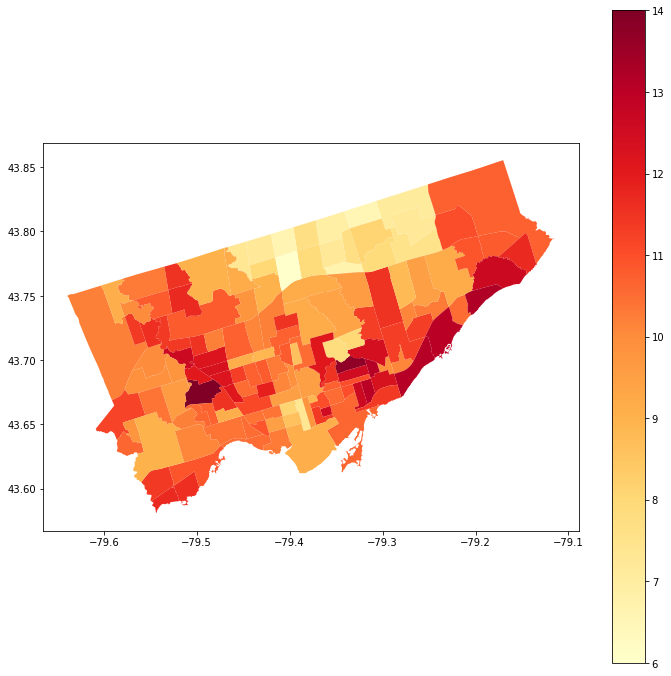

In [47]:
#generate our figure/axes and set fig size
fig, axes = plt.subplots(1, 1, figsize = (12,12))

#let's map asthma percent rates across toronto!
nbrhd_simple.plot(column = "asthma_pct",
                  legend = True, ax = axes, 
                  cmap = "YlOrRd")

### Hmm - Looks like there are some spatial patterns!

We can also look at non-spatial figures to explore our data. Doing this helps us understand the 'shape' of our data in different ways. 

Let's create a histogram of the same data in the following cell:

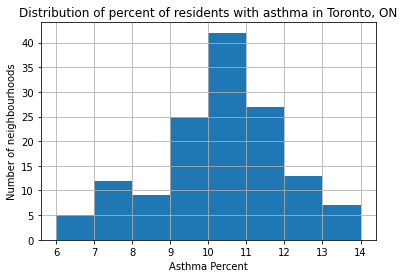

In [48]:
# Just like what we do in pandas
nbrhd_simple['asthma_pct'].hist(bins=8)

plt.xlabel('Asthma Percent')
plt.ylabel('Number of neighbourhoods')
plt.title('Distribution of percent of residents with asthma in Toronto, ON')
plt.show()

### Interesting!

This looks like a "normal" distribution: 
- Many neighbourhoods with values in the middle range, but some at the extremes (both low and high). 

But when we look at the map, we notice that neighbourhoods with high values tend to be near other neighbourhoods with high values, and low value neighbourhoods near others with low values. 

Maybe there is some spatial mechanism causing this!


### To dig into this more, let's classify the data using quartiles...

To do this we add a `scheme` parameter to the plot function and use `quantiles`. the `k` value tells the plot function how many quantiles you want. We want four quantiles (0-25%, 25%-50%, 50%-75%, 75%-100%).

More information about [`plot`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) function 

We do this for a few reasons: 
- (1) It makes it easier to see groups with similar values that are close to eachother and 
- (2) it makes the legend easier to interpret.

Note that we also have added an `edgecolor` parameter which tells the map what color to outline neighbourhoods with.

<AxesSubplot:>

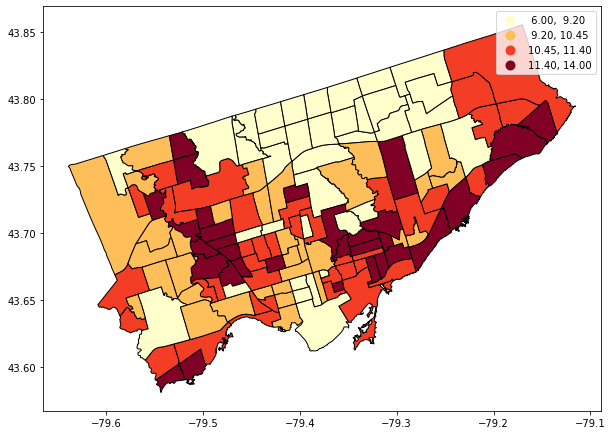

In [49]:
fig, axes = plt.subplots(1,1, figsize =  (10,10))
nbrhd_simple.plot(column='asthma_pct', scheme='quantiles', 
                  k=4, cmap='YlOrRd', edgecolor='black', 
                  ax = axes, legend=True)


This map looks a lot better, I think! But the legend is overlapping the map. We should move it. 

The legend options are kind of complicated, but you can find more about stuff here: https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.legend.html

I'm going to show you a few things you can do, like move the legend, adjust font size, and add a title:

<AxesSubplot:>

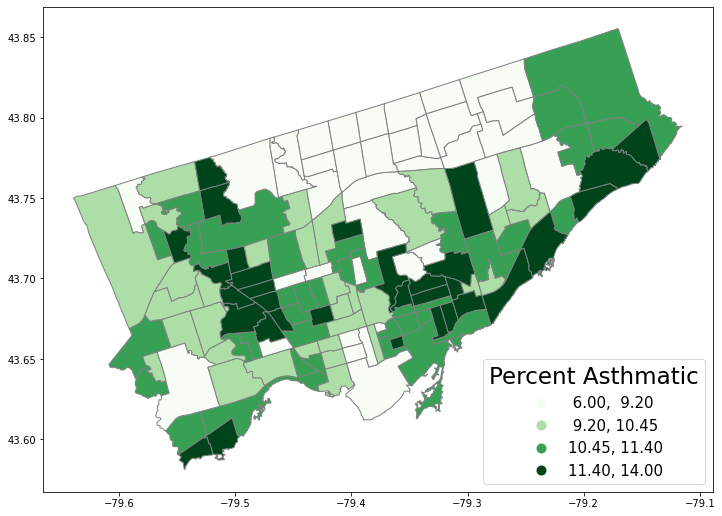

In [50]:
fig, axes = plt.subplots(1,1, figsize =  (12,12))

nbrhd_simple.plot(column='asthma_pct', scheme='quantiles', 
                  k=4, cmap='Greens', edgecolor='grey', 
                  ax = axes, legend=True, 
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic',
                               'title_fontsize': 23,'fontsize': 15}) #'loc'=4 means lower right

Can we show descriptive stats charts next to a map? 

Yes!


Text(0.5, 1.0, 'Distribution of percent of residents with asthma in Toronto, ON')

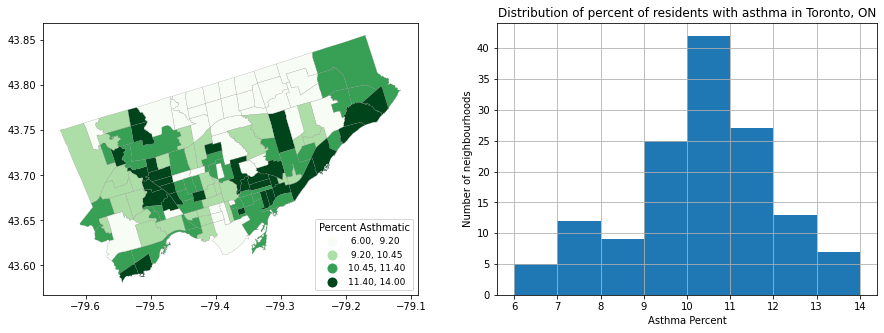

In [51]:
#First create a figure sheet with 2 axes cells (and resize the figure)
fig, axes = plt.subplots(1,2, figsize = (15,5))

#let's put the map in the first axes cell:
nbrhd_simple.plot(column='asthma_pct', scheme='quantiles', 
                  k=4, cmap='Greens', edgecolor='grey', linewidth = 0.2, #notice I added linewidth to narrow the borders
                  ax = axes[0], legend=True, 
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 10,'fontsize': 9})

#we can put the histogram we made earlier in the second axes cell:
nbrhd_simple['asthma_pct'].hist(bins=8, ax = axes[1])
plt.xlabel('Asthma Percent')
plt.ylabel('Number of neighbourhoods')
plt.title('Distribution of percent of residents with asthma in Toronto, ON')

# First steps into "spatial analysis"...

OK great! That chart is interesting and gets us thinking. But one of the powers of spatial analysis is relating environments to spatial phenomena.

#### What might be related to these areas with higher asthma? 

Let's make a map with multiple layers of info...

To do this, we need a second spatial data file. We know there is research that relates asthma to being near railroads. Let's see if being near a railway in Toronto is associated to patterns of asthma.

<AxesSubplot:>

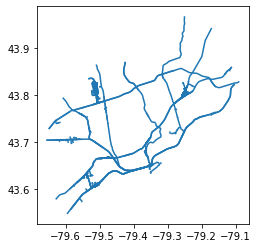

In [52]:
#first we need to bring in the spatial data on railroads in the Toronto area

railways = gpd.GeoDataFrame.from_file("toronto_rails.geojson")
railways.plot()

#### Coordinate systems and projections

When working with spatial data, you may need to think about coordinate systems and geographic projections.

Because we are taking data that exist on a sphere and laying them out flat on a plane, all spatial data is projected.

![projections](https://cdn-images-1.medium.com/fit/t/1600/480/1*H96H7Gn9EcfZH5tEmMoSXg.gif)

If you have two layers of spatial data it is always good to check that they are in the same projection, or else you will get errors or bad results.

If the files are not in the same projection, it's pretty simple to convert one of the files to the same projection as the other file:

The original projection of railways is:  EPSG:4269
The original projection of nbrhd_simple is:  EPSG:4326
The NEW projection of railways is:  EPSG:4326
And nbrhd_simple is still:  EPSG:4326


<AxesSubplot:>

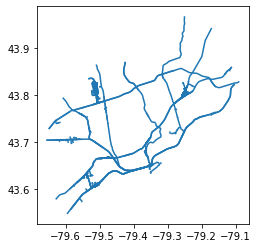

In [53]:
# double check coordinate systems - we always want to work in the same projection

print("The original projection of railways is: ", railways.crs)
print("The original projection of nbrhd_simple is: ", nbrhd_simple.crs)

# reproject railways so it's the same as our neighbourhood layer
railways = railways.to_crs(nbrhd_simple.crs) #we can just borrow the "crs" (coordinate reference system) from the other spatial file
print("The NEW projection of railways is: ", railways.crs)
print("And nbrhd_simple is still: ", nbrhd_simple.crs)
railways.plot()

In [54]:
nbrhd_simple.head()

,name_x,nbrhd_spat_id,geometry,Neighbid,name_y,asthma_pct
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,10.1
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95,Annex,9.5
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109,Caledonia-Fairbank,11.3
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",64,Woodbine Corridor,13.0
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103,Lawrence Park South,10.7


### Now that our two geodataframe spatial layers are in the same projection, we can plot them together

We want to create 1 map and tell geopandas to put the two spatial layers in the same axes cell:

<AxesSubplot:>

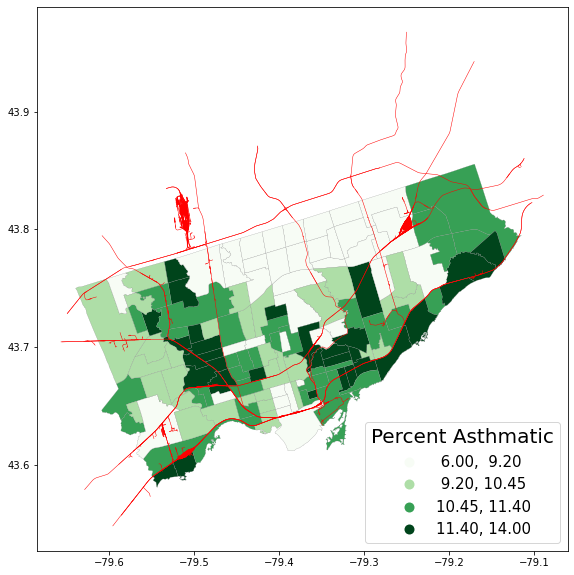

In [55]:
fig, axes = plt.subplots(1,1, figsize = (15,10))



nbrhd_simple.plot(column='asthma_pct', scheme='quantiles', 
                  k=4, cmap='Greens', edgecolor='grey',
                  linewidth = .2, ax = axes, legend=True, 
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 20,'fontsize': 15})

railways.plot(edgecolor="red", linewidth = .5, ax = axes) #notice i'm putting this in the same axes cell


In [56]:
railways.columns

Index(['OBJECTID', 'OGF_ID', 'TRACKNID', 'TRACKSEGID', 'TRACKNAME',
       'TRACKCLASS', 'REGULATOR', 'TRANSPTYPE', 'USETYPE', 'GAUGE',
       'NUMTRACKS', 'ELECTRIC', 'STATUS', 'SPEEDFREIT', 'SPEEDPASSE',
       'UNITOFSPEE', 'SOURCEID', 'OPERATOENA', 'OPERATOFNA', 'OPERATORMK',
       'OPSUBSTART', 'OPSUBEND', 'OPSUBUDIS', 'OWNERENA', 'OWNERFNA',
       'TRKUSR1ENA', 'TRKUSR1FNA', 'TRKUSR1RMK', 'TRKUSR2ENA', 'TRKUSR2FNA',
       'TRKUSR2RMK', 'TRKUSR3ENA', 'TRKUSR3FNA', 'TRKUSR3RMK', 'TRKUSR4ENA',
       'TRKUSR4FNA', 'TRKUSR4RMK', 'SUBDI1NID', 'SUBDI1NAME', 'SUBD1START',
       'SUBD1END', 'SUB1UNITDI', 'SUBDI2NID', 'SUBDI2NAME', 'SUBD2START',
       'SUBD2END', 'SUB2UNITDI', 'ADMINAREA', 'SPECVERS', 'SECURCLASS',
       'GEOCREDATE', 'GEOREVDATE', 'GEOACQTECH', 'GEOACCURA', 'GEOPROVIDE',
       'ATTCREDATE', 'ATTREVDATE', 'ATTACQTECH', 'ATTPROVIDE', 'EFFECTIVE_',
       'SHAPE_Leng', 'SHAPE_1_Le', 'geometry'],
      dtype='object')

### Hmm - could there be something there? 

Maybe!

But what are the things that might be happening here? 

### Let's do a "spatial join"

What is a spatial join? 

![alt text](https://web.natur.cuni.cz/~langhamr/lectures/vtfg1/mapinfo_1/about_gis/Image23.gif)

Basically, we are relating information from two tables that share a spatial relationship. 

So information from layer a's table will be joined with information from layer b's table where the two intersect/touch/are within/etc.

We will use "intersect" here, but you can refer to the geopandas documentation to learn more:

https://geopandas.org/en/stable/gallery/spatial_joins.html

In [57]:
join_left_df = nbrhd_simple.sjoin(railways, how="left", predicate = "intersects")
join_left_df


,name_x,nbrhd_spat_id,geometry,Neighbid,name_y,asthma_pct,index_right,OBJECTID,OGF_ID,TRACKNID,...,GEOACQTECH,GEOACCURA,GEOPROVIDE,ATTCREDATE,ATTREVDATE,ATTACQTECH,ATTPROVIDE,EFFECTIVE_,SHAPE_Leng,SHAPE_1_Le
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,10.1,1280.0,1720.0,10131.0,2579cdd5ccaf447e93bec017362a451a,...,Vector Data,10.0,Provincial/Territorial,201306,None,Vector Data,Federal,2013-07-30,0.0,0.026163
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,10.1,3222.0,8267.0,16018.0,ced49be659214db99e606ea1f3153f03,...,Vector Data,10.0,Provincial/Territorial,201306,None,Vector Data,Federal,2013-07-30,0.0,0.043467
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,10.1,888.0,9370.0,17250.0,05f860e758f746be971872822cb137c8,...,Vector Data,10.0,Provincial/Territorial,201306,None,Vector Data,Federal,2013-07-30,0.0,0.060344
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,10.1,1844.0,10459.0,3086.0,1fd8c25a828f46829c173713f49c63d3,...,Vector Data,10.0,Provincial/Territorial,201306,None,Vector Data,Federal,2013-07-30,0.0,0.008783
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95,Annex,9.5,1280.0,1720.0,10131.0,2579cdd5ccaf447e93bec017362a451a,...,Vector Data,10.0,Provincial/Territorial,201306,None,Vector Data,Federal,2013-07-30,0.0,0.026163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Humbermede (22),022,"POLYGON ((-79.52628 43.73640, -79.52649 43.736...",22,Humbermede,10.8,1239.0,9798.0,2436.0,816b3f97bace44149b88174dc78a7e55,...,Orthoimage,10.0,Federal,201306,None,Vector Data,Federal,2013-07-30,0.0,0.002236
137,Humbermede (22),022,"POLYGON ((-79.52628 43.73640, -79.52649 43.736...",22,Humbermede,10.8,2305.0,15763.0,8280.0,9da306e9415d4e7fa5b006a39dc550c1,...,Orthoimage,10.0,Federal,201306,None,Vector Data,Federal,2013-07-30,0.0,0.002528
137,Humbermede (22),022,"POLYGON ((-79.52628 43.73640, -79.52649 43.736...",22,Humbermede,10.8,717.0,5591.0,13590.0,632d434dd2b24ef5aaf8544d87f467f5,...,Orthoimage,10.0,Federal,201306,None,Vector Data,Federal,2013-07-30,0.0,0.012516
138,Willowdale West (37),037,"POLYGON ((-79.44043 43.76340, -79.44052 43.763...",37,Willowdale West,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:

join_left_df.loc[join_left_df['TRACKNID'].isnull()]

,name_x,nbrhd_spat_id,geometry,Neighbid,name_y,asthma_pct,index_right,OBJECTID,OGF_ID,TRACKNID,...,GEOACQTECH,GEOACCURA,GEOPROVIDE,ATTCREDATE,ATTREVDATE,ATTACQTECH,ATTPROVIDE,EFFECTIVE_,SHAPE_Leng,SHAPE_1_Le
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103,Lawrence Park South,10.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Henry Farm (53),053,"POLYGON ((-79.35966 43.76649, -79.35966 43.766...",53,Henry Farm,6.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Pleasant View (46),046,"POLYGON ((-79.34346 43.79517, -79.34359 43.795...",46,Pleasant View,7.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Steeles (116),116,"POLYGON ((-79.34132 43.81565, -79.33988 43.816...",116,Steeles,6.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Brookhaven-Amesbury (30),030,"POLYGON ((-79.50296 43.69574, -79.50415 43.696...",30,Brookhaven-Amesbury,12.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Yonge-Eglinton (100),100,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",100,Yonge-Eglinton,10.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Englemount-Lawrence (32),032,"POLYGON ((-79.43854 43.70586, -79.43855 43.705...",32,Englemount-Lawrence,10.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Bridle Path-Sunnybrook-York Mills (41),041,"POLYGON ((-79.39008 43.72768, -79.39016 43.728...",41,Bridle Path-Sunnybrook-York Mills,9.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,Danforth East York (59),059,"POLYGON ((-79.34627 43.68272, -79.34645 43.683...",59,Danforth Village-East York,12.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,Elms-Old Rexdale (5),005,"POLYGON ((-79.55512 43.71510, -79.55569 43.716...",5,Elms-Old Rexdale,11.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Woah!

Now we have 2528 rows... that's way more rows than neighbourhoods. What happened?

Spatial join creates a new row for every instance of 'intersection'. So if railway 1 and railway 2 both go through neighbourhood a, then there will be two rows with neighbourhood a with one row joined with railway a data and the other joined with railway b data. 

Also, notice that neighbourhoods that didn't have any railway go through them were appended with NaNs. This is saying there is no data about railways for these neighbourhoods because there were none there.

Because we just want to know what neighbourhoods have *ANY* railway go through them, we can take the joined results and remove duplicate rows of each neighbourhood.

In [59]:
no_duplicates_gdf = join_left_df.copy()
no_duplicates_gdf = no_duplicates_gdf.drop_duplicates('Neighbid')
no_duplicates_gdf.shape


(140, 69)

#### Let's check this new, no duplicate geodataframe to see if looks right.

We can plot the map using "index_right" which is the index from the railway layer. The values are meaningless, but it shows us where there ARE values and where there are not. 

<AxesSubplot:>

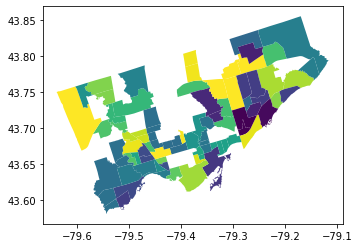

In [60]:
no_duplicates_gdf.plot(column = "index_right")

#### This looks good, based on visual inspection

But we need a column that tells us there IS or there IS NOT a railway in each neighbourhood. We can go back to some of the skills we learned earlier in the course to do this. 

We will first create two series of TRUE and FALSE values to show where a value exists in the "index_right" column.

The series `rail_present` will be true if there is a value in the column - implying a railway goes through the neighbourhood, and false otherwise.

The series `rail_not_present` will be true if there is a NaN value in the row where the railway info is, and false otherwise.

In [61]:
rail_present = no_duplicates_gdf["index_right"] >= 0
rail_present.value_counts()

True     85
False    55
Name: index_right, dtype: int64

In [62]:
rail_not_present = no_duplicates_gdf["index_right"].isnull()
rail_not_present.value_counts()

False    85
True     55
Name: index_right, dtype: int64

### Let's clean things up a little and create the final geodataframe we want to work with

We can clean things up and then create a map and a descriptive statistics plot to show our findings.

In [63]:
#create list of columns relevant to our analysis
columns_to_keep = ["name_x","Neighbid","name_y","asthma_pct","index_right","geometry"]

#create our final analysis geodataframe and create a column 'rail_present' that is true 
#if railways are in the neighbourhood and false if not:
final_toronto_analysis = no_duplicates_gdf[columns_to_keep].copy()
final_toronto_analysis.loc[rail_present, 'rail_present'] = True
final_toronto_analysis.loc[rail_not_present, 'rail_present'] = False
final_toronto_analysis.head()

,name_x,Neighbid,name_y,asthma_pct,index_right,geometry,rail_present
0,Casa Loma (96),96,Casa Loma,10.1,1280.0,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",True
1,Annex (95),95,Annex,9.5,1280.0,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",True
2,Caledonia-Fairbank (109),109,Caledonia-Fairbank,11.3,1305.0,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",True
3,Woodbine Corridor (64),64,Woodbine Corridor,13.0,1940.0,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",True
4,Lawrence Park South (103),103,Lawrence Park South,10.7,NaN,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",False


Text(0.5, 0.98, 'Percent of Population with Asthma for Neighbourhoods with Railways')

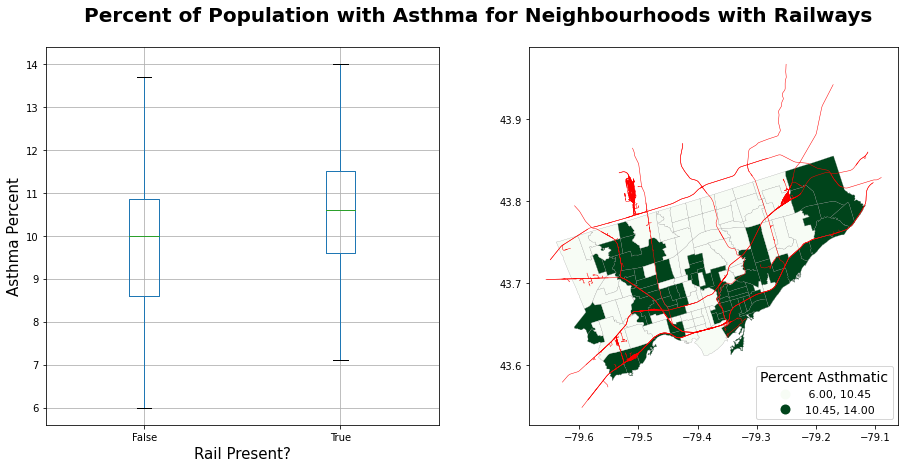

In [64]:
fig, axes = plt.subplots(1,2, figsize = (15,7))

final_toronto_analysis.boxplot(column="asthma_pct", 
                               by = "rail_present", 
                               ax = axes[0])

final_toronto_analysis.plot(column='asthma_pct', scheme='quantiles', 
                  k=2, cmap='Greens', edgecolor='grey', linewidth = 0.2, 
                  ax = axes[1], legend=True, 
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 14,'fontsize': 11})
railways.plot(ax=axes[1], edgecolor='red',linewidth=0.5)

axes[0].set_title("")
axes[0].set_ylabel("Asthma Percent", fontsize = 15)
axes[0].set_xlabel("Rail Present?", fontsize = 15)

fig.suptitle("Percent of Population with Asthma for Neighbourhoods with Railways", 
             fontsize = 20, fontweight = "bold")

It seems that the presence of railway in neighborhood is related to higher asthma rate! 

But is it a **significant** relationship?

Remember the comparison between two groups before!

Let's do a hypothesis testing using shuffling method.

- Null hypothesis: There is no differences of asthma rates between neighborhoods with railways and without railways.

- Alternative hypothesis: Neighborhoods with railways have higher asthma rates than the neighborhoods without railways.

Let's do a exercise.

In [65]:
# Simulation
simulated_diffs = []

for _ in range(5000):
    simulated = final_toronto_analysis['rail_present'].sample(frac=1, replace = False).reset_index(drop = True)
    mean_railway = final_toronto_analysis.loc[simulated == True, 'asthma_pct'].mean()
    mean_norailway = final_toronto_analysis.loc[simulated == False, 'asthma_pct'].mean()
    sim_diff = mean_railway - mean_norailway
    simulated_diffs.append(sim_diff)

# Calculate observed difference
obs_mean_railway = final_toronto_analysis.loc[final_toronto_analysis['rail_present'] == True, 'asthma_pct'].mean()
obs_mean_norailway = final_toronto_analysis.loc[final_toronto_analysis['rail_present'] == False, 'asthma_pct'].mean()

obs_diff = obs_mean_railway - obs_mean_norailway

# Calculate p-value
simulated_diffs_df = pd.DataFrame({'sim_diffs' : simulated_diffs})

numgreater = (simulated_diffs_df['sim_diffs'] >= obs_diff).sum()
print('The number of simulated differences greater than the observed difference is:', numgreater)

numsmaller = (simulated_diffs_df['sim_diffs'] < -1 * obs_diff).sum()
print('The number of simulated differences smaller than the observed difference is:', numsmaller)

pvalue = (numgreater + numsmaller)/ 5000

print('The p-value is:', pvalue)

The number of simulated differences greater than the observed difference is: 11
The number of simulated differences smaller than the observed difference is: 13
The p-value is: 0.0048


Great! We can say the asthma rates in neighborhoods with railways are significantly higher than the rates in neighborhoods without railways.

But is this a causal relationship?